In [9]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
sys.path.insert(0,'../environments/'); import gw
#sys.path.insert(0,'../environments/'); import gridworld_plotting as gp
sys.path.insert(0,'../rl_network/'); import actorcritic as ac
#sys.path.insert(0,'../memory/'); import episodic as ec


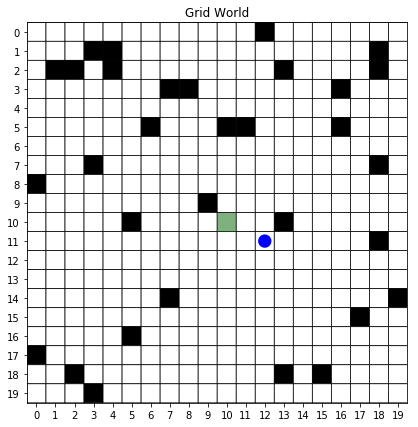

In [10]:
rows, columns = 20, 20 
env = gw.GridWorld(rows=rows,cols=columns, 
                   rewards={(int(rows/2),int(columns/2)):1},
                   step_penalization=-0.01,
                   rho=0.1)
fig = gw.plotWorld(env,current_state=True,scale=0.35)

In [12]:
reload(ac)


agent_params = { 
    'load_model':  False,
    'load_dir':     f'../data/outputs/gridworld/openfield{rows}{columns}.pt',
    'freeze_w':    False,
    
    'input_dims':  (env.observation.shape[1],env.observation.shape[2],env.observation.shape[0]),
    'action_dims': len(env.action_list),
    'hid_types':   ['conv', 'pool', 'linear'],
    'lin_dims':    [500],
    'rfsize':      5,
    'stride':      1,
    'padding':     1,
    'dilation':    1,
    
    'gamma':       0.98,
    'eta':         5e-4,
    
    'use_EC':      True,
    'EC':          {},
    'cachelim':    300,
    'mem_temp':    0.3    
}

MF, opt = ac.make_agent(agent_params)

run_dict = {
    'NUM_EVENTS': 300,
    'NUM_TRIALS': 2000,
    'environment': env,
    'agent': MF,
    'optimizer': opt,
    'agt_param': agent_params
}


[(18, 18, 3), (16, 16, 3), 500]


In [ ]:
print(env.state, oneD2twoD(env.state, env.shape))
fig = plotWorld(env,current_state=False)

num_steps = 10
moves = True
if moves:
    for _ in range(num_steps):
        if _ == 0:
            action_choice = ""
        start_at = oneD2twoD(env.state, env.shape)
        # draw state
        agent_y, agent_x = oneD2twoD(env.state, env.shape)
        agent_dot = plt.Circle((agent_x + .5, agent_y + .5), 0.35, fc='b')
        fig.gca().add_artist(agent_dot)

        # select action
        action_choice = random_policy(env)
        env.move(action_choice)

        print(f"{start_at}:{action_choice} --> {oneD2twoD(env.state, env.shape)}")
        text = plt.gcf().text(0.1, 0.9, f'Agent Chooses: {action_choice}', fontsize=14)

        plt.pause(1)
        plt.draw()
        dx1, dy1, head_w, head_l = make_arrows(env.action_dict[action_choice])
        if action_choice == 'P':
            arrow = plt.text(agent_x+0.49, agent_y+0.6, "*", {'color': 'white', 'fontsize': 24, 'ha': 'center', 'va': 'center'})
        else:
            arrow = plt.arrow(agent_x+0.5, agent_y+0.5, dx1, dy1, head_width=0.3, head_length=0.2, color="cyan")


        plt.pause(.5)
        plt.draw()

        if _ < num_steps-1:
            agent_dot.remove()
            arrow.remove()
            text.remove()
plt.show()